### Approximating the integral

It is easy to see that as we use large $n$ (i.e., more qubits) and thus larger $b_{\mbox{max}}$, we can approximate the integral better as illustrated below. 

In [1]:
import math

b_max = math.pi / 100  # upper limit of integral # 5
nbit = 10  # change this value to get discretized result closer to analytical results # 3

analyticResult = (b_max / 2.0 - math.sin(2 * b_max) / 4.0 ) / b_max  # the target integral can be analytically solved
print("Analytical Result:", analyticResult)

ndiv = 2**nbit  #number of discretization 
discretizedResult = 0.0
for i in range(ndiv):
    discretizedResult += math.sin(b_max / ndiv * (i + 0.5))**2
discretizedResult = discretizedResult / ndiv
print("Discretized Result:", discretizedResult)

Analytical Result: 0.00032892188007938847
Discretized Result: 0.0003289218016943769


### Grover Operators for Amplitude Estimation

We can easily build quantum circuits for fast computation of the Monte Carlo integration as below. Here, we show functions to construct quantum circuits running with simulators. Running them on real devices should be easy by adjusting the parameters of the functions.  

In [2]:
import sys
sys.path.append('../libmitigation')

In [3]:
#Preparing qiskit environment
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute
from qiskit import IBMQ
from qiskit import Aer
from scipy import optimize
import sys, time
import mpmath as mp
import numpy as np
import matplotlib.pyplot as plt

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/qiskit/__init__.py:67: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of the 0.17.0 release. Support for running Qiskit with Python 3.6 will be removed in a future release.
  "future release.", DeprecationWarning)


In [4]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import depolarizing_error
import qiskit.ignis.mitigation as mit
from qiskit.ignis.mitigation.measurement import tensored_meas_cal, TensoredMeasFitter
import importlib
from inv_sgs import InvSGS
from inv_s_sgs import InvSSGS
from inv_lm_sgs import InvLMSGS
from inv_s_lm_sgs import InvSLMSGS
from inv_s_lm0_sgs import InvSLM0SGS
from inv_s_lmk_sgs import InvSLMkSGS
from mooney_etal import MooneyEtal
from sgs_algorithm import sgs_algorithm
from lib_grover import *

For example, quantum circuit with two Grover operators is shown below.

/Users/yangbo/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/qiskit/visualization/matplotlib.py:291: DeprecationWarning: style option/s (usepiformat, cregbundle, compress) is/are not supported
  set_style(current_style, style)


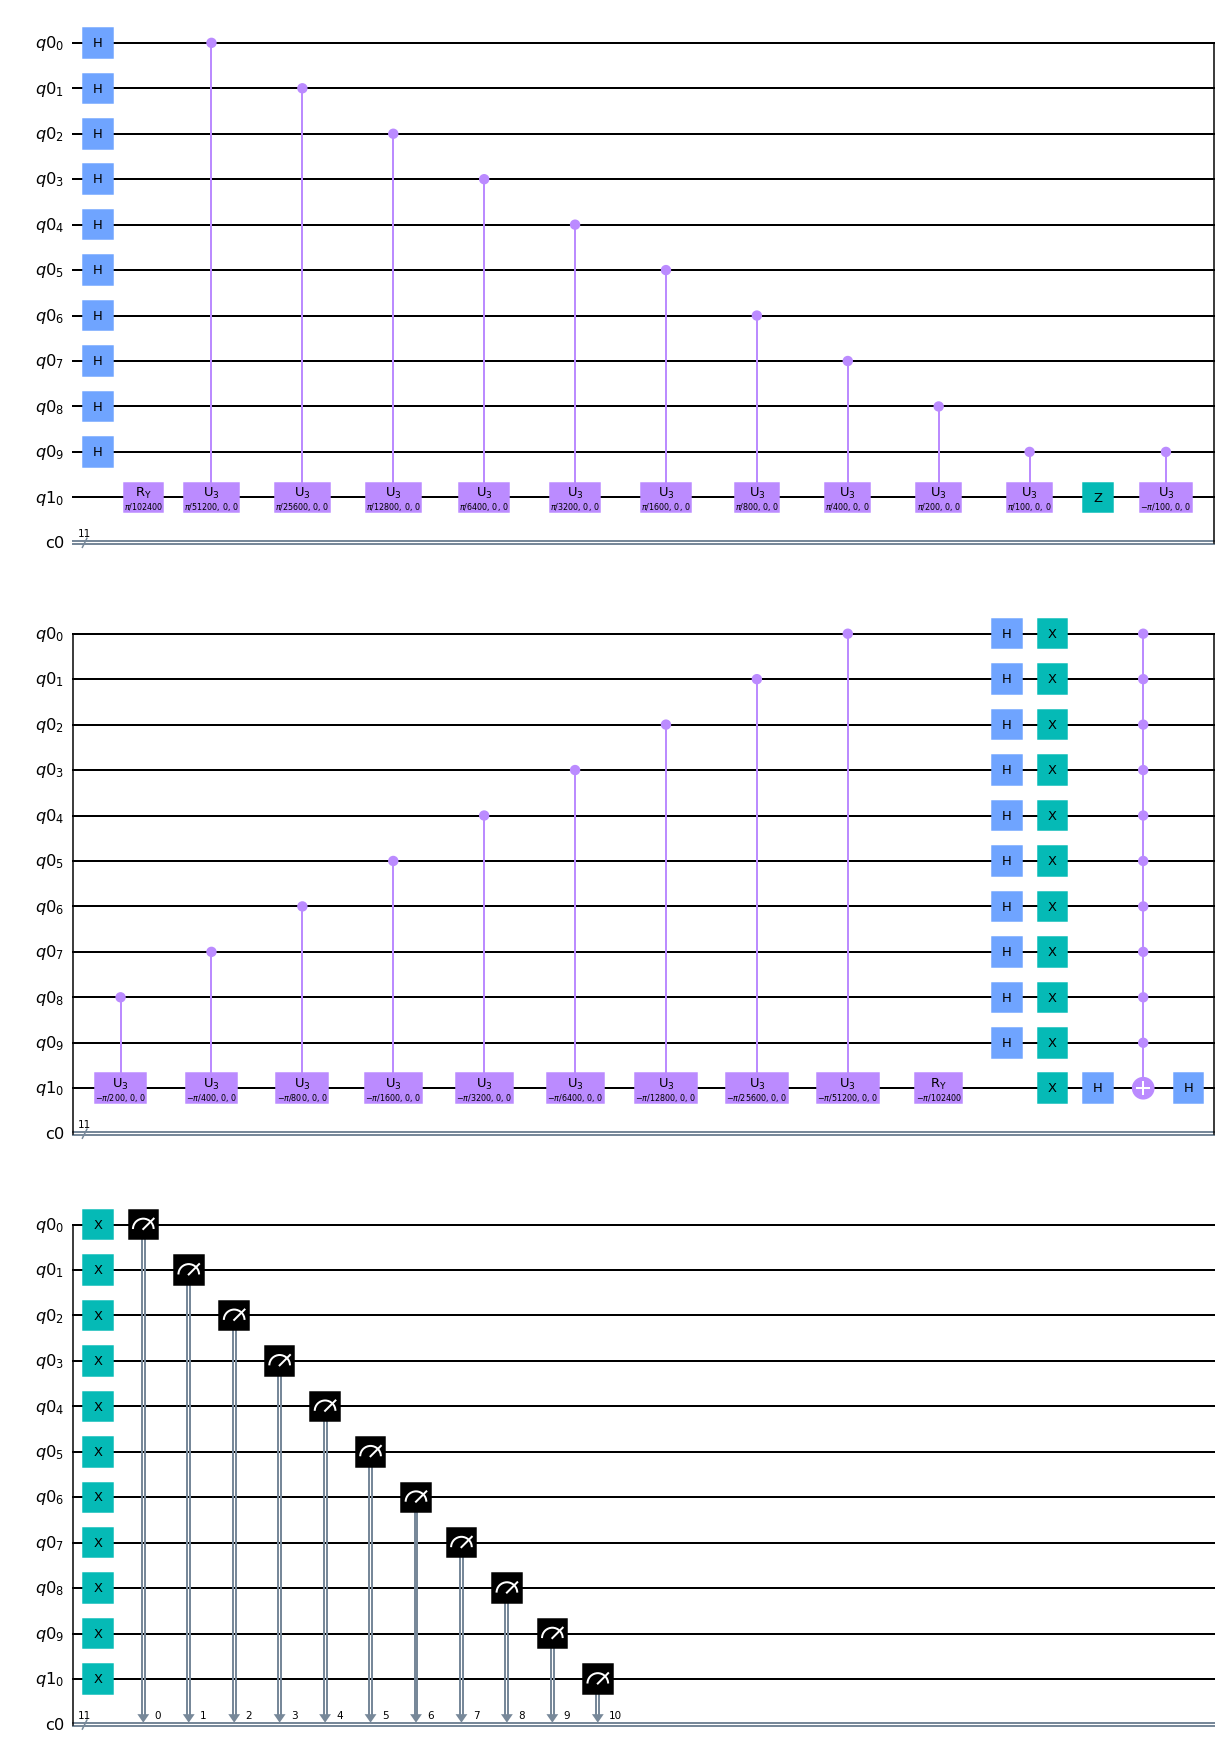

In [5]:
qc_list = create_grover_circuit([1], nbit, b_max)
my_style = {'usepiformat': True, 'cregbundle': True,'compress': True }
qc_list[0].draw(output="mpl", style=my_style, plot_barriers=False )

## Testing the algorithm with simulators

Let us run the algorithm with simulators

In [6]:
#setting the number of shots and Grover operators.

# number_grover_list = [0, 1, 2, 4, 8, 16, 32] # , 64, 128, 256]  # list of number of Grover operators
number_grover_list = [i for i in range(100)]
shots_list = [100] * len(number_grover_list) # list of number of shots
if len(shots_list) != len(number_grover_list):
    raise Exception(
        'The length of shots_list should be equal to the length of number_grover_list.'
    )

backend = Aer.get_backend('qasm_simulator')

In [7]:
noise_model = NoiseModel()
for qi in range(nbit+1):
    if qi >= 0:
        read_err = ReadoutError([[0.97, 0.03],[0.03,0.97]])
        noise_model.add_readout_error(read_err, [qi])

Finally, we can run the algorithm as below: 

In [13]:
qc_list = create_grover_circuit(number_grover_list, nbit,b_max)  # list of Grover circuits

In [14]:
counts_list = run_grover(qc_list, number_grover_list, shots_list, backend, noise_model=noise_model)  # list of number of grover operators

0 th round with 0 oracles
0.8005099296569824 s
1 th round with 1 oracles
0.015468120574951172 s
2 th round with 2 oracles
0.02153611183166504 s
3 th round with 3 oracles
0.02810811996459961 s
4 th round with 4 oracles
0.03495192527770996 s
5 th round with 5 oracles
0.04166579246520996 s
6 th round with 6 oracles
0.04672408103942871 s
7 th round with 7 oracles
0.05466318130493164 s
8 th round with 8 oracles
0.0709998607635498 s
9 th round with 9 oracles
0.06825590133666992 s
10 th round with 10 oracles
0.07099294662475586 s
11 th round with 11 oracles
0.07741308212280273 s
12 th round with 12 oracles
0.08180880546569824 s
13 th round with 13 oracles
0.08634686470031738 s
14 th round with 14 oracles
0.09831404685974121 s
15 th round with 15 oracles
0.1028749942779541 s
16 th round with 16 oracles
0.11097311973571777 s
17 th round with 17 oracles
0.11501908302307129 s
18 th round with 18 oracles
0.12122392654418945 s
19 th round with 19 oracles
0.13090205192565918 s
20 th round with 20 or

In [15]:
import pickle
with open("raw_result_10_003_003.pkl", "wb") as f:
    pickle.dump(counts_list, f)

In [8]:
import pickle
with open("raw_result_10_003_003.pkl", "rb") as f:
    counts_list = pickle.load(f)

In [9]:
hit_list = make_hit_list(counts_list)
print(hit_list)

[75, 70, 74, 66, 74, 74, 70, 71, 71, 63, 54, 55, 55, 59, 51, 53, 61, 47, 40, 48, 42, 39, 28, 32, 34, 28, 31, 23, 18, 20, 13, 17, 13, 7, 10, 4, 13, 5, 2, 1, 4, 2, 1, 3, 4, 0, 2, 4, 2, 3, 6, 3, 3, 8, 14, 13, 18, 13, 13, 12, 24, 35, 24, 34, 29, 42, 28, 34, 43, 53, 55, 50, 56, 64, 68, 54, 66, 54, 63, 60, 70, 73, 63, 71, 75, 71, 73, 69, 76, 68, 67, 80, 69, 78, 76, 65, 69, 69, 62, 60]


In [10]:
shots = 8192
qr = QuantumRegister(nbit+1)
mit_pattern = [[i] for i in range(nbit+1)]
meas_calibs, state_labels = tensored_meas_cal(mit_pattern=mit_pattern, qr=qr, circlabel='mcal')
job = execute(meas_calibs, backend=Aer.get_backend('qasm_simulator'), shots=shots, noise_model=noise_model)
cal_results = job.result()
meas_fitter = TensoredMeasFitter(cal_results, mit_pattern=mit_pattern)

In [11]:
meas_filter = InvSGS(nbit+1, meas_fitter.cal_matrices, mit_pattern)
mit_counts_list = []
for counts in counts_list:
    x_tilde = meas_filter.apply(counts)
    mit_counts_list.append(x_tilde)
mit_hit_list = make_hit_list(mit_counts_list)

strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.999999999999998
number of positive values:  1027
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000002
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000007
number of positive values:  1023
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999967
number of positive values:  1021
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.000000000000002
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000004
number of positive values:  1035
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000009
number of positive values:  1022
main process: Done!
strict i

sum of mitigated probability vector x: 1.000000000000001
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 0.9999999999999997
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000002
number of positive values:  1026
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000004
number of positive values:  1024
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.000000000000003
number of positive values:  1025
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000024
number of positive values:  1022
main process: Done!
strict inverse + SGS algorithm
sum of mitigated probability vector x: 1.0000000000000009
number of positive values:  1025
main process: Done!
strict inverse + SGS algorithm
sum of m

In [12]:
meas_filter = InvSLM0SGS(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_S_lm_0_list = []
for counts in counts_list:
    x_tilde = meas_filter.apply(counts)
    x_tilde_S_lm_0_list.append(x_tilde)
mit_hit_S_lm_0_list = make_hit_list(x_tilde_S_lm_0_list)
print(mit_hit_S_lm_0_list)

Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0400115290832184
sum of mitigated probability vector x_hat_s: 1.040036804562999
number of positive values:  8
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0827524799882404
sum of mitigated probability vector x_hat_s: 1.0827746110965342
number of positive values:  8
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0820817397776454
sum of mitigated probability vector x_hat_s: 1.0821038942402423
number of positive values:  9
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.0749353089578801
sum of mitigated probability vector x_hat_s: 1.0749607596410415
number of positive values:  13
main process: Done!
Restriction to labels of y + Lagrange Multip

sum of mitigated probability vector x_s: 1.151245245037689
sum of mitigated probability vector x_hat_s: 1.1513272369963954
number of positive values:  22
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.1462538699019504
sum of mitigated probability vector x_hat_s: 1.1463121858464405
number of positive values:  16
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.132498191393911
sum of mitigated probability vector x_hat_s: 1.1325672267414584
number of positive values:  21
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.17421065440419
sum of mitigated probability vector x_hat_s: 1.174258593644566
number of positive values:  16
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.14

sum of mitigated probability vector x_s: 1.1249176358657396
sum of mitigated probability vector x_hat_s: 1.1249542833852388
number of positive values:  16
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.1783543792848685
sum of mitigated probability vector x_hat_s: 1.1783845629448866
number of positive values:  14
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.1319285594490878
sum of mitigated probability vector x_hat_s: 1.1319678533608695
number of positive values:  20
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 1.066534297645528
sum of mitigated probability vector x_hat_s: 1.0665641518167992
number of positive values:  14
main process: Done!
Restriction to labels of y + Lagrange Multiplier + SGS algorithm
sum of mitigated probability vector x_s: 

In [13]:
meas_filter = MooneyEtal(nbit+1, meas_fitter.cal_matrices, mit_pattern)
x_tilde_mooney_list = []
for counts in counts_list:
    x_tilde = meas_filter.apply(counts, threshold=1/100)
    x_tilde_mooney_list.append(x_tilde)
mit_hit_mooney_list = make_hit_list(x_tilde_mooney_list)
print(mit_hit_mooney_list)

The heuristcs by Mooney et al. + SGS algorithm
{128: -0.017189153753851476, 8: -0.017591381246648868, 1: 0.020300323308064087, 192: 0.013667576288419544, 256: -0.021488491005420444, 1028: 0.013722754881191703, 32: -0.018936560567047987, 544: 0.013869514159775496, 1024: -0.023281372255545704, 16: 0.024598601928438425, 0: 1.0487293722499462}
sum of counts: 1.036401183987321
number of positive values:  6
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{512: 0.012111634555649994, 8: 0.054272523685706384, 64: -0.01457894973282094, 1: -0.019483908836853105, 0: 0.9763315067309083, 1024: 0.020414499275114156, 1032: 0.024469550011670112}
sum of counts: 1.0535368556893747
number of positive values:  5
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{18: 0.013422425989741376, 36: 0.013396388446328221, 64: 0.011890149548992838, 288: 0.014067167575065716, 1284: 0.014088593355859314, 512: -0.01749381433456376, 0: 1.0341502948999275}
sum of counts: 1.083521205481

{1409: 0.013954135057963946, 1536: 0.1340623570345264, 1537: 0.022802946868047357, 1056: 0.022180592823237373, 0: 0.21933984465264839, 1024: 0.6238594967855621, 1280: 0.06219596047620675}
sum of counts: 1.0983953336981924
number of positive values:  7
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{1096: 0.013987830372174563, 1552: 0.021497373021601734, 1025: 0.020973516371752158, 1152: 0.02410579537557333, 1280: 0.049204915723453785, 0: 0.16484779603913358, 1040: 0.02276506173162009, 6: 0.014272392224351138, 1416: 0.014010502719501406, 1024: 0.5957226255287648, 1536: 0.17633297920185467}
sum of counts: 1.117720788309781
number of positive values:  11
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{513: 0.01411333491310134, 1552: 0.023065269199285632, 1088: 0.03265836908999581, 1156: 0.013745208728070935, 1536: 0.14260792969725525, 1024: 0.7848375557202447, 0: 0.07465619781585855, 1312: 0.027105753352199592}
sum of counts: 1.112789618516012
numbe

{576: 0.012876450325555493, 256: -0.01760041588023279, 66: 0.012804705788784504, 8: -0.01421744836211062, 128: 0.014788477255691622, 16: 0.02798196794343103, 1056: 0.01123524092515982, 64: -0.014130029706637372, 32: 0.05465092445721219, 2: 0.0319618480506734, 0: 0.9324196368489097, 512: 0.027692034065492813}
sum of counts: 1.08046339171193
number of positive values:  9
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{1024: -0.012661161518473942, 256: -0.02475492711814506, 1280: 0.013895273662040752, 272: 0.012866218599533224, 1536: 0.013245342078262222, 16: 0.021971515679615302, 160: 0.014138201500341752, 0: 1.1222099142989452, 2: -0.014912745501150081}
sum of counts: 1.1459976316809692
number of positive values:  6
main process: Done!
The heuristcs by Mooney et al. + SGS algorithm
{321: 0.01396495133534911, 32: -0.016264114223352496, 8: -0.015000980466138748, 128: -0.01554253600216924, 1152: 0.027782422636415314, 1: 0.03723559914348519, 64: 0.028032475448843214, 153

In [22]:
import pickle
with open("hit_list_10_003_003.pkl", "wb") as f:
    pickle.dump(hit_list, f)

In [14]:
import pickle
with open("mit_hit_list_10_003_003.pkl", "wb")as f:
    pickle.dump(mit_hit_list, f)

In [24]:
"""
import pickle
with open("mit_hit_S_list_10_003_003.pkl", "wb")as f:
    pickle.dump(mit_hit_S_list, f)
"""

In [15]:
import pickle
with open("mit_hit_S_lm_0_list_10_003_003.pkl", "wb")as f:
    pickle.dump(mit_hit_S_lm_0_list, f)

In [16]:
import pickle
with open("mit_hit_mooney100_list_10_003_003.pkl", "wb") as f:
    pickle.dump(mit_hit_mooney_list, f)

In [17]:
with open("hit_list_10_003_003.pkl", "rb") as f:
    hit_list = pickle.load(f)
with open("mit_hit_list_10_003_003.pkl", "rb") as f:
    mit_hit_list = pickle.load(f)
with open("mit_hit_S_list_10_003_003.pkl", "rb") as f:
    mit_hit_S_list = pickle.load(f)
with open("mit_hit_S_lm_0_list_10_003_003.pkl", "rb") as f:
    mit_hit_S_lm_0_list = pickle.load(f)
with open("mit_hit_mooney100_list_10_003_003.pkl", "rb") as f:
    mit_hit_S_lm_0_list = pickle.load(f)

Text(0, 0.5, 'number of shots for $|00...0>$')

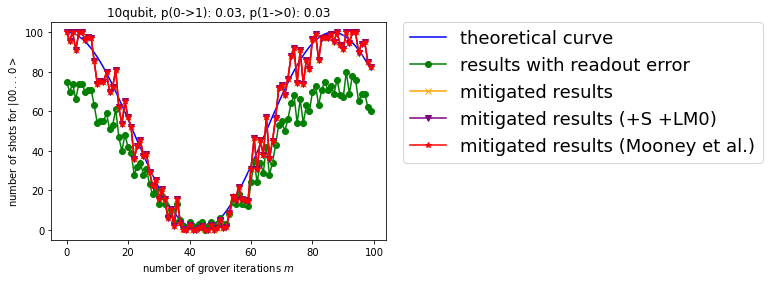

In [17]:
divide = 100
number_grover_list = [i for i in range(100)]
plt.plot(np.linspace(0,number_grover_list[-1], divide), 100 * np.cos(2 * np.linspace(0,number_grover_list[-1], divide) * np.arccos(np.sqrt(discretizedResult))) ** 2, label="theoretical curve", color="blue")
plt.plot(number_grover_list, hit_list, marker="o", label="results with readout error", color="green")
plt.plot(number_grover_list, mit_hit_list, marker="x", label="mitigated results", color="orange")
plt.plot(number_grover_list, mit_hit_S_lm_0_list, marker="v", label="mitigated results (+S +LM0)", color="purple")
plt.plot(number_grover_list, mit_hit_mooney_list, marker="*", label="mitigated results (Mooney et al.)", color="red")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.title("10qubit, p(0->1): 0.03, p(1->0): 0.03")
plt.xlabel("number of grover iterations $m$")
plt.ylabel("number of shots for $|00...0>$")

# Afterwards

In [18]:
sin_hit_list = [100 - h for h in hit_list]
sin_mit_hit_list = [100 - h for h in mit_hit_list]
sin_mit_hit_S_lm_0_list = [100 - h for h in mit_hit_S_lm_0_list]
sin_mit_hit_mooney_list = [100 - h for h in mit_hit_mooney_list]

thetaCandidate_list = calculate_theta(
    sin_hit_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_list = calculate_theta(
    sin_mit_hit_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_S_lm_0_list = calculate_theta(
    sin_mit_hit_S_lm_0_list, number_grover_list, shots_list)  # list of estimated theta values
thetaCandidate_mit_mooney_list = calculate_theta(
    sin_mit_hit_mooney_list, number_grover_list, shots_list)  # list of estimated theta values

error_list = np.abs(np.sin(thetaCandidate_list)**2 - discretizedResult)  # list of estimation errors
error_mit_list = np.abs(np.sin(thetaCandidate_mit_list)**2 - discretizedResult)  # list of estimation errors
error_mit_S_lm_0_list = np.abs(np.sin(thetaCandidate_mit_S_lm_0_list)**2 - discretizedResult)  # list of estimation errors
error_mit_mooney_list = np.abs(np.sin(thetaCandidate_mit_mooney_list)**2 - discretizedResult)  # list of estimation errors
OracleCall_list = []  # list of number of oracle calls
ErrorCramérRao_list = []  # list of Cramér-Rao lower bound
for i in range(len(number_grover_list)):
    OracleCall_list.append(
        CalcNumberOracleCalls(i, shots_list, number_grover_list))
    ErrorCramérRao_list.append(
        CalcErrorCramérRao(i, shots_list, discretizedResult, number_grover_list))

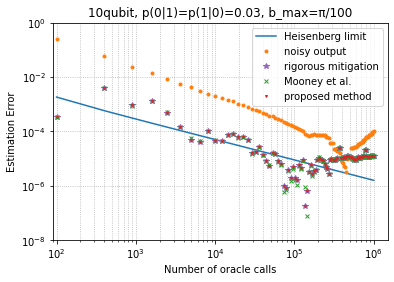

In [21]:
plt.clf()
p = plt.loglog( OracleCall_list, ErrorCramérRao_list)
p0 = plt.loglog( OracleCall_list, error_list, 'o', markersize=3)
p1 = plt.loglog( OracleCall_list, error_mit_list, '*', color='C4', markersize=6)
p2 = plt.loglog( OracleCall_list, error_mit_mooney_list, 'x', color='C2', markersize=4)
p3 = plt.loglog( OracleCall_list, error_mit_S_lm_0_list, 'v', color='C3', markersize=2)

plt.title("10qubit, p(0|1)=p(1|0)=0.03, b_max=π/100")
plt.xlim(OracleCall_list[0]*0.9, OracleCall_list[-1]*1.5)
plt.xlabel("Number of oracle calls")
plt.ylim(0.00000001, 1)
plt.ylabel("Estimation Error")
plt.grid(True, which="both", ls="dotted")
plt.legend((p[0], p0[0], p1[0], p2[0], p3[0]), ("Heisenberg limit", "noisy output", "rigorous mitigation", "Mooney et al.", "proposed method"))
plt.show()